In [12]:
# %reload_ext snakeviz
%matplotlib inline
%run SBRG.py
import matplotlib.pyplot as plt

Required package: 
- Numpy, 
- Numba (to accelerate entropy calculation), 
- Qutip (easy to compare with ED results)

# Core
## Pauli Algebra
Pauli matrix class. A Pauli matrix is denoted as
$$\sigma=\mathrm{i}^{x\cdot z}\prod_{i\in Xs}X_i\prod_{i\in Zs}Z_i=\mathrm{i}^{x\cdot z}\prod_{i}X_i^{x_i}Z_i^{z_i},$$
where $x_i=\delta(i\in Xs)$, $z_i=\delta(i\in Zs)$ are vectors of 0,1, and $X_i$, $Z_i$ are the Pauli matrix on site $i$.

Pauli matrices can be created by `mkMat`
- from Xs, Zs sets: `mkMat(Xs, Zs)`,
- or from dict of indices: `mkMat({i:mu, ...})`,
- or from list of indices: `mkMat([m0, mu1, ...])`.

In [2]:
[mkMat({0,1},{1,2}), mkMat({0:1,1:2,2:3}), mkMat([1,2,3])]

[<Xs:[0, 1] Zs:[1, 2]>, <Xs:[0, 1] Zs:[1, 2]>, <Xs:[0, 1] Zs:[1, 2]>]

`Mat` is hashable and can be compared.

In [5]:
print(hash(mkMat()))
mkMat() == mkMat([])

-1999641754715938413


True

The commutativity of two Pauli operators can be checked by `is_commute`

In [7]:
is_commute(mkMat([0,1,0]),mkMat([1,2,3]))

False

Merge two Pauli operators by indices. Coefficients are not calculated here. The coefficient can be restored from the commutation relations later.

In [8]:
pdot(mkMat([0,1,0]),mkMat([1,2,3]))

<Xs:[0] Zs:[1, 2]>

### Pauli Monomial
A term of Pauli operator `Term.mat` with a constant multiple `Term.val`.

In [9]:
[Term(), Term(mkMat([1,2])),Term(mkMat([1,2]),-3.2)]

[1.0 <Xs:[] Zs:[]>, 1.0 <Xs:[0, 1] Zs:[1]>, -3.2 <Xs:[0, 1] Zs:[1]>]

Consider $\sigma_A=\mathrm{i}^{x_A\cdot z_A} X_A Z_A$, $\sigma_B=\mathrm{i}^{x_B\cdot z_B} X_B Z_B$, then the product reads:
$$\sigma_A\sigma_B=\mathrm{i}^{x_A\cdot z_A+x_B\cdot z_B+2 z_A\cdot x_B}\quad (X_A X_B) (Z_A Z_B)=\mathrm{i}^{x_A\cdot z_A+x_B\cdot z_B-x_C\cdot z_C+2 z_A\cdot x_B}\quad \mathrm{i}^{x_C\cdot z_C}X_C Z_C=\mathrm{i}^{n^{C}_{AB}}\; \sigma_C,$$
where $X_C=X_AX_B$, $Z_C=Z_AZ_B$ and $z_C = (z_A+z_B)\mod 2$. The power of $\mathrm{i}$ is
$$n^{C}_{AB}=x_A\cdot z_A+x_B\cdot z_B-x_C\cdot z_C+2 z_A\cdot x_B$$

In [10]:
dot(Term(mkMat([1,2])),Term(mkMat([3,3])))

1.0 <Xs:[0, 1] Zs:[0]>

In [11]:
idot(Term(mkMat([2,0])),Term(mkMat([3,3])))

-1.0 <Xs:[0] Zs:[1]>

## Hamiltonian
Hamiltonian `Ham` is a sum of Pauli monomial terms. It can be created from a list of terms.

In [12]:
H = Ham(
    [Term(mkMat([0,1,1]),0.5),
     Term(mkMat([3,0,0]),0.2),
     Term(mkMat([0,3,3]),0.8),
     Term(mkMat([1,3,0]),1.0)])
H

[1.0 <Xs:[0] Zs:[1]>, 0.8 <Xs:[] Zs:[1, 2]>, 0.5 <Xs:[1, 2] Zs:[]>, 0.2 <Xs:[] Zs:[0]>]

For our purpose, we generate Clifford algebra by $C_4$ rotation $R_{C4}$, like $\pi/4$ phase gate
$$R_{C4}(\sigma^{[\mu]})=\exp\left(i\dfrac{\pi}{4}\sigma^{[\mu]}\right)=\dfrac{1}{\sqrt{2}}(1+i \sigma^{[\mu]})$$

Its adjoint on matrix $\sigma^{[\nu]}$ is given by
$$R_{C4}^{\dagger}(\sigma^{[\mu]})\sigma^{[\nu]}R_{C4}(\sigma^{[\mu]})=i\sigma^{[\nu]}\sigma^{[\mu]},~\text{if they anti-commute}; \sigma^{[\nu]},~\text{otherwise}$$

We can use SBRG to calculate C4 rotation on a Hamiltonian

In [29]:
H = Ham(
    [Term(mkMat([0,1]),0.5),
     Term(mkMat([3,0]),0.2)])
print('Hamiltonian: ', H)

Hamiltonian:  [0.5 <Xs:[1] Zs:[]>, 0.2 <Xs:[] Zs:[0]>]


In [30]:
H.C4(Term(mkMat([0,2])))

In [31]:
print('Hamiltonian after rotation:', H)

Hamiltonian after rotation: [-0.5 <Xs:[] Zs:[1]>, 0.2 <Xs:[] Zs:[0]>]


We can also use a list to contain a serial of $R_{C4}$ rotations, and use ".forward()" function to rotate Hamiltonain sequentially.

In [9]:
H = Ham(
    [Term(mkMat([0,1]),0.5),
     Term(mkMat([3,0]),0.2)])
print('Hamiltonian: ', H)
C4_list = [Term(mkMat([0,2])),Term(mkMat([2,0]))]
H.forward(C4_list)
print('Hamiltonian after rotation: ', H)

Hamiltonian:  [0.5 <Xs:[1] Zs:[]>, 0.2 <Xs:[] Zs:[0]>]
Hamiltonian after rotation:  [-0.5 <Xs:[] Zs:[1]>, 0.2 <Xs:[0] Zs:[]>]


### Create your own physical model of disorder systems

A model will be contained in the `Model()` class. Here we will demostrate how to create your own model with `SBRG`.

Here, we demostrate how to create the random transverse field Ising model with periodic boundary condition using `Model` class:
$$H=-\sum_{i}J_i X_i X_{i+1}-\sum_{i}K_i Z_i Z_{i+1}-\sum_i h_i Z_i$$

In [3]:
# quantum Ising model
def TFIsing(L, **para):
    # L - number of sites (assuming PBC)
    # model - a dict of model parameters
    try: # set parameter alpha
        alpha = para['alpha']
        alpha_J = alpha
        alpha_K = alpha
        alpha_h = alpha
    except:
        alpha_J = para.get('alpha_J',1)
        alpha_K = para.get('alpha_K',1)
        alpha_h = para.get('alpha_h',1)
    model = Model()
    model.size = L
    H_append = model.terms.append
    rnd_beta = random.betavariate
    for i in range(L):
        H_append(Term(mkMat({i: 1, (i+1)%L: 1}), -para['J']*rnd_beta(alpha_J, 1)))
        H_append(Term(mkMat({i: 3, (i+1)%L: 3}), -para['K']*rnd_beta(alpha_K, 1)))
        H_append(Term(mkMat({i: 3}), -para['h']*rnd_beta(alpha_h, 1)))
    model.terms = [term for term in model.terms if abs(term.val) > 0]
    return model

Now we can use it to generate random Hamiltonians for transverse field Ising model!

In [6]:
H = TFIsing(10,**{'alpha':1, 'J':0, 'K':1, 'h':0.1})

We can print the terms in our model:

In [8]:
H.terms

[-0.48572974013884723 <Xs:[] Zs:[0, 1]>,
 -0.059097006883942094 <Xs:[] Zs:[0]>,
 -0.0897059941452797 <Xs:[] Zs:[1, 2]>,
 -0.07112631839444992 <Xs:[] Zs:[1]>,
 -0.5821475468076082 <Xs:[] Zs:[2, 3]>,
 -0.022970783432911458 <Xs:[] Zs:[2]>,
 -0.2399389264057369 <Xs:[] Zs:[3, 4]>,
 -0.08783283255320778 <Xs:[] Zs:[3]>,
 -0.7406664685936012 <Xs:[] Zs:[4, 5]>,
 -0.04630675848533874 <Xs:[] Zs:[4]>,
 -0.31876036382042083 <Xs:[] Zs:[5, 6]>,
 -0.02007830434504277 <Xs:[] Zs:[5]>,
 -0.31521431052572696 <Xs:[] Zs:[6, 7]>,
 -0.07166554977654012 <Xs:[] Zs:[6]>,
 -0.6401070249267768 <Xs:[] Zs:[7, 8]>,
 -0.017347636845403618 <Xs:[] Zs:[7]>,
 -0.8014594487501201 <Xs:[] Zs:[8, 9]>,
 -0.059306524053466814 <Xs:[] Zs:[8]>,
 -0.09348520331545136 <Xs:[] Zs:[0, 9]>,
 -0.055869428458517424 <Xs:[] Zs:[9]>]

### Bridge to `Qutip` package

`Qutip` is an open source python package for quantum system simulation. 

And we have build the tool to transform SBRG `Ham` class object to `Qutip` Qobj class object.

To transform SBRG Hamiltonian to Qutip Hamiltonian, you can use `system_Ham_to_qutip_Ham(system_size, SBRG_Hamiltonian)`

Links to `Qutip` documents: [Link](http://nbviewer.ipython.org/urls/raw.github.com/jrjohansson/qutip-lectures/master/Lecture-0-Introduction-to-QuTiP.ipynb)

Suppose we create a `SBRG` Hamiltonian:

In [2]:
H = Ham(
    [Term(mkMat([0,1]),0.5),
     Term(mkMat([3,0]),0.2)])

We can transform it to `Qutip` Hamiltonian:

In [3]:
Qutip_H = system_Ham_to_qutip_Ham(2,H)
print(Qutip_H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.2  0.5  0.   0. ]
 [ 0.5  0.2  0.   0. ]
 [ 0.   0.  -0.2  0.5]
 [ 0.   0.   0.5 -0.2]]


Let's try transverse field Ising model Hamiltonian:

In [9]:
H = TFIsing(10,**{'alpha':1, 'J':0, 'K':1, 'h':0.1})

In [10]:
Qutip_H = system_Ham_to_qutip_Ham(10, H)

In [11]:
print(Qutip_H)

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (1024, 1024), type = oper, isherm = True
Qobj data =
[[-4.60562593  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -3.17050846  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -3.74091324 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -3.07485983  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -2.43888095
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -3.84782262]]


## SBRG

### How to use SBRG algorithm diagonalizing our Hamiltonian iteratively?

In [4]:
model = TFIsing(10,**{'alpha':1, 'J':0, 'K':1, 'h':0.1})
system = SBRG(model)

There are some hyperparameters that controls how many new terms generated by perturbation theory are going to be kept:

SBRG.tol      :: float : terms with energy < leading energy * tol will be truncated

SBRG.max_rate :: float : each RG step allows at most (max_rate * num of off-diagonal terms) amount of new terms

In [5]:
system.tol = 0.
system.max_rate = 1000.
system.run()

Now the Hamiltonian is fully diagonalized. We can check the effective Hamiltonian, and find it is all in pauli-Z basis.

In [6]:
system.Heff

[-0.8471429109758388 <Xs:[] Zs:[8]>,
 -0.7614193443532637 <Xs:[] Zs:[3]>,
 -0.5621343906315225 <Xs:[] Zs:[1]>,
 -0.5052207409000993 <Xs:[] Zs:[2]>,
 -0.4177129411140818 <Xs:[] Zs:[7]>,
 -0.3540462605305455 <Xs:[] Zs:[6]>,
 -0.29607711006323434 <Xs:[] Zs:[0]>,
 -0.2908548086283606 <Xs:[] Zs:[5]>,
 -0.11559725720325642 <Xs:[] Zs:[0, 1, 2, 3, 4, 5, 6, 7, 8]>,
 -0.24171484683537453 <Xs:[] Zs:[4]>,
 -0.08681025162618483 <Xs:[] Zs:[0, 5, 6, 7, 8, 9]>,
 -0.08368237754345108 <Xs:[] Zs:[5, 6, 9]>,
 -0.001316658051464393 <Xs:[] Zs:[5, 9]>,
 -0.06129571982521144 <Xs:[] Zs:[5, 6, 7, 9]>,
 -0.09458017502250247 <Xs:[] Zs:[9]>,
 -0.0834564751781167 <Xs:[] Zs:[3, 4, 9]>,
 -0.07519053593659264 <Xs:[] Zs:[1, 2, 3, 4, 9]>,
 -0.09045835546239792 <Xs:[] Zs:[5, 6, 7, 8, 9]>,
 -0.022864345459538422 <Xs:[] Zs:[2, 3, 4, 9]>,
 -0.028130556456352564 <Xs:[] Zs:[4, 9]>]

We can find the ground state, and its associated energy by `.grndstate_blk()` function.

In [7]:
ground_state, energy = system.grndstate_blk()

In [8]:
print('ground state is indicated by the effective bulk spins:')
ground_state

ground state is indicated by the effective bulk spins:


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
energy

-5.01970606179739

Instead of just getting ground state, you can also get the full spectrum of your Hamiltonian

In [10]:
full_spectrum = get_full_spectrum(system)

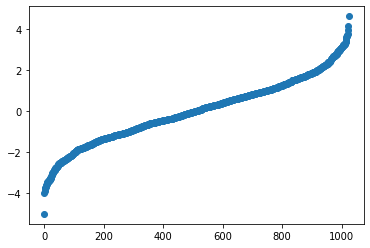

In [16]:
plt.plot(sorted(full_spectrum),'o')

## Expectation value of physical observables

## Entanglement Entropy